In [1]:
import json
import pickle
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp


In [2]:
import os
import sys

# Get the current notebook's directory
current_directory = os.getcwd()

# Get the parent directory
parent_directory = os.path.dirname(os.path.dirname(current_directory))

# Add the parent directory to the module search path
sys.path.insert(0, parent_directory)
print(parent_directory)

from data.pdb_utils import VOCAB

/n/holylabs/LABS/mzitnik_lab/Users/afang/GET


In [54]:
aa_nucleotides = [
    'SER', 'THR', 'TYR', 'ASN', 'GLN', 'CYS', # polar
    'TRP', 'TYR', # aromatic
    'HIS', 'LYS', 'ARG', # positive
    'RA', 'RC', 'RU', 'RG',
    'DA', 'DT', 'DC', 'DG',
]

In [4]:
interact_scores_file = "/n/holyscratch01/mzitnik_lab/afang/GET/interact_score/PDNA_valid.json"
interaction_profile_file = "/n/holyscratch01/mzitnik_lab/afang/GET/intermolecular_interactions/QBioLiP_PDNA_valid.json"
raw_data_file = "/n/holylabs/LABS/mzitnik_lab/Users/afang/GET/datasets/BioLiP/processed-QBioLiP/QBioLiP_PDNA_valid.pkl"

In [5]:
interact_scores = []
with open(interact_scores_file, "r") as f:
    for line in f.readlines():
        interact_scores.append(json.loads(line))
interact_scores_id = [x["id"] for x in interact_scores]
len(interact_scores)

239

In [6]:
interaction_profiles = []
with open(interaction_profile_file, "r") as f:
    for line in f.readlines():
        interaction_profiles.append(json.loads(line))
interaction_profiles_id = [x["id"] for x in interaction_profiles]
len(interaction_profiles)

239

In [7]:
with open(raw_data_file, "rb") as f:
    raw_data = pickle.load(f)
raw_data_ids = [d["id"] for d in raw_data]
len(raw_data_ids)

239

In [8]:
# FIXME: the IDs are non unique
from collections import Counter
count_ids = Counter(raw_data_ids)
valid_ids = [k for k, v in count_ids.items() if v == 1]
len(valid_ids)

239

In [9]:
ids = set(interaction_profiles_id).intersection(set(interact_scores_id))
ids = ids.intersection(set(valid_ids))
len(ids)

239

In [10]:
list_interaction_atoms = []
for i in range(len(interaction_profiles)):
    interaction_atoms = {}
    interaction_atoms['id'] = interaction_profiles[i]['id']
    if interaction_profiles[i]['id'] not in ids:
        continue
    
    data = raw_data[raw_data_ids.index(interaction_profiles[i]['id'])]['data']
    block_ids = [id for id, length in enumerate(data["block_lengths"]) for _ in range(length)]
    
    for profile_type, profile in interaction_profiles[i].items():
        if not isinstance(profile, list):
            continue
        atoms = []
        for profile_entry in profile:
            for k, v in profile_entry.items():
                if 'orig_idx' in k:
                    if isinstance(v, list):
                        atoms.extend(v)
                    else:
                        atoms.append(v)
        atom_blocks = []
        for atom in atoms:
            if atom >= len(block_ids):
                print(f"atom {atom} out of range", interaction_profiles[i]['id'])
            atom_blocks.append((atom, block_ids[atom]))
        interaction_atoms[profile_type] = atom_blocks
    list_interaction_atoms.append(interaction_atoms)
len(list_interaction_atoms)

239

In [11]:
def get_blocks(interaction_atoms):
    blocks = []
    for profile_type, profile in interaction_atoms.items():
        if profile_type == "id":
            continue
        new_blocks = [block for atom, block in profile]
        blocks.extend(new_blocks)
    blocks = list(set(blocks))
    return blocks

In [12]:
def jaccard_index(set1, set2):
    if type(set1) == list:
        set1_ = set(set1)
        assert len(set1) == len(set1_), "list1 contains duplicates"
        set1 = set1_
    if type(set2) == list:
        set2_ = set(set2)
        assert len(set2) == len(set2_), "list2 contains duplicates"
        set2 = set2_
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union)

In [13]:
def get_topk_jaccard(list_interaction_atoms, interact_scores, interact_scores_id, k, rand_residues=None):
    # rand_residues are the residues we can pick the random blocks from
    top_jaccard = []
    rand_jaccard = []
    for interaction_atoms in list_interaction_atoms:
        gt_blocks = get_blocks(interaction_atoms)
        interact_scores_item = interact_scores[interact_scores_id.index(interaction_atoms['id'])]
        if len(interact_scores_item['block_idx']) <= k:
            continue
        topk = [idx for _, idx in sorted(list(zip(interact_scores_item['cos_distances'], interact_scores_item['block_idx'])))[:k]]

        if rand_residues is not None:
            all_blocks = []
            data = raw_data[raw_data_ids.index(interaction_atoms['id'])]['data']
            for b in interact_scores_item['block_idx']:
                blocktype = VOCAB.idx_to_abrv(data['B'][b])
                if blocktype in aa_nucleotides:
                    all_blocks.append(b)
        else:
            all_blocks = interact_scores_item['block_idx']
        if len(all_blocks) <= k:
            continue
        randk = random.sample(all_blocks, k)
        top_jaccard.append(jaccard_index(gt_blocks, topk))
        rand_jaccard.append(jaccard_index(gt_blocks, randk))
    return top_jaccard, rand_jaccard

Num samples: 210
0.5900126422250316 9.758108715934969e-36 0.5142857142857142 1.1237606289990178e-25


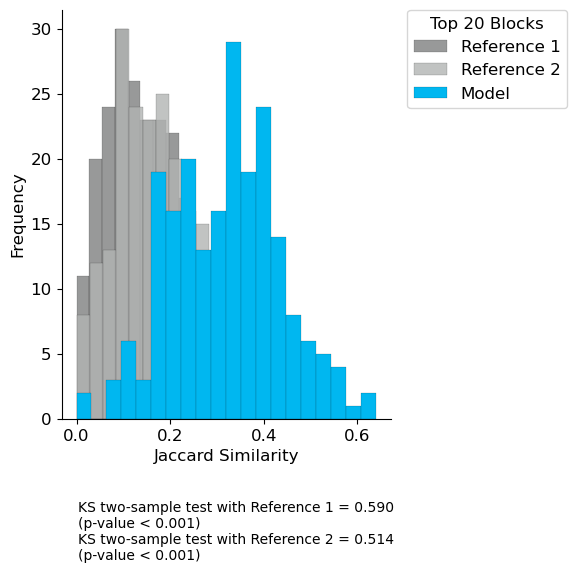

In [105]:
k = 20
top_jaccard, rand2_jaccard = get_topk_jaccard(list_interaction_atoms, interact_scores, interact_scores_id, k, rand_residues=aa_nucleotides)
_, rand_jaccard = get_topk_jaccard(list_interaction_atoms, interact_scores, interact_scores_id, k)
print("Num samples:", len(top_jaccard))
plt.figure(figsize = (6, 6))
plt.rcParams.update({'font.size': 12})
df = {"topk_jaccards": top_jaccard, "rand_jaccards": rand_jaccard, "rand2_jaccards": rand2_jaccard}
ax = sns.histplot(data = df, x = "rand_jaccards", label = "Reference 1", bins = 20, color = "#545655", alpha = 0.6)
ax = sns.histplot(data = df, x = "rand2_jaccards", label = "Reference 2", bins = 20, color = "#b2b4b3", alpha = 0.8)
ax = sns.histplot(data = df, x = "topk_jaccards", label = "Model", bins = 20, color = "#00b7f0", alpha = 1)
plt.xlabel("Jaccard Similarity")
plt.ylabel("Frequency")
plt.setp(ax.patches, linewidth=0.1)
ks_stat, ks_p = ks_2samp(top_jaccard, rand_jaccard)
ks_stat2, ks_p2 = ks_2samp(top_jaccard, rand2_jaccard)
print(ks_stat, ks_p, ks_stat2, ks_p2)
textstr = f"KS two-sample test with Reference 1 = {ks_stat:.3f} \n(p-value < {ks_p+0.001:.3f})\nKS two-sample test with Reference 2 = {ks_stat2:.3f} \n(p-value < {ks_p2+0.001:.3f})"
plt.text(x=0.05, y=-0.2, s=textstr, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', fontdict={'family': 'sans-serif'})
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title=f"Top {k} Blocks")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig("mask_mutagenesis_PDNA.png", dpi=300)
# plt.close()
plt.show()

In [56]:
print(ks_2samp(top_jaccard, rand_jaccard))
print(ks_2samp(top_jaccard, rand2_jaccard))

KstestResult(statistic=0.5523809523809524, pvalue=8.49323502125872e-30, statistic_location=0.20754716981132076, statistic_sign=-1)
KstestResult(statistic=0.6325326590813316, pvalue=1.9002363740785327e-41, statistic_location=0.20689655172413793, statistic_sign=-1)


True
29
True
17


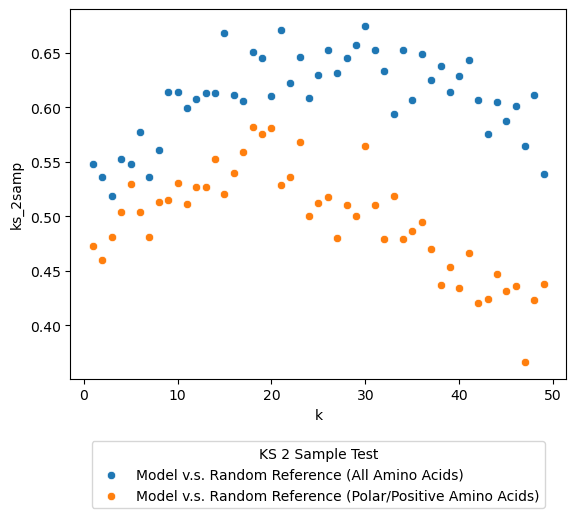

In [57]:
maxk = 50
ks_2samp_results = []
num_valid_ids = []
ks_2samp_pval = []
for k in range(1,maxk):
    top_jaccard, rand_jaccard = get_topk_jaccard(list_interaction_atoms, interact_scores, interact_scores_id, k)
    ks_2samp_results.append(ks_2samp(top_jaccard, rand_jaccard).statistic)
    num_valid_ids.append(len(top_jaccard))
    ks_2samp_pval.append(ks_2samp(top_jaccard, rand_jaccard).pvalue)
df = {"k": list(range(1,maxk)), "ks_2samp": ks_2samp_results, "p_value": ks_2samp_pval, "num_valid_ids": num_valid_ids}
sns.scatterplot(data = df, x = "k", y = "ks_2samp", label="Model v.s. Random Reference (All Amino Acids)")
print(all([x < 0.001 for x in ks_2samp_pval]))
print(ks_2samp_results.index(max(ks_2samp_results)))
# sns.barplot(data = df, x = "k", y = "num_valid_ids", alpha = 0.5, color = "red", label="Number of Valid IDs")
# sns.scatterplot(data = df, x = "k", y = "p_value", alpha = 0.5, color = "green", label="P Value")

ks_2samp_results = []
num_valid_ids = []
ks_2samp_pval = []
for k in range(1,maxk):
    top_jaccard, rand_jaccard = get_topk_jaccard(list_interaction_atoms, interact_scores, interact_scores_id, k, rand_residues=aa_nucleotides)
    ks_2samp_results.append(ks_2samp(top_jaccard, rand_jaccard).statistic)
    num_valid_ids.append(len(top_jaccard))
    ks_2samp_pval.append(ks_2samp(top_jaccard, rand_jaccard).pvalue)
df = {"k": list(range(1,maxk)), "ks_2samp": ks_2samp_results}
print(all([x < 0.001 for x in ks_2samp_pval]))
print(ks_2samp_results.index(max(ks_2samp_results)))
sns.scatterplot(data = df, x = "k", y = "ks_2samp", label="Model v.s. Random Reference (Polar/Positive Amino Acids)")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), title="KS 2 Sample Test")
plt.show()

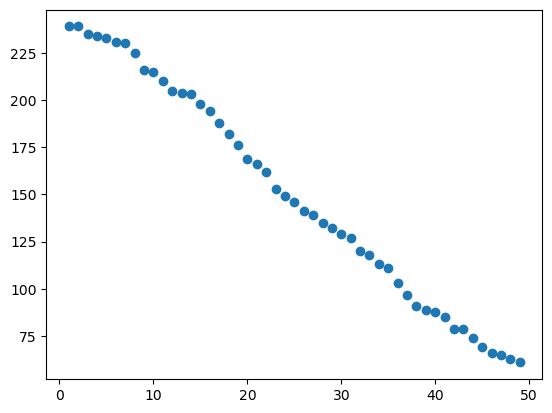

In [90]:
plt.scatter(range(1,maxk), num_valid_ids)

In [115]:
num_interactions = []
for interaction_atoms in list_interaction_atoms:
    blocks = get_blocks(interaction_atoms)
    assert len(blocks) == len(set(blocks)), "duplicates in blocks"
    num_interactions.append(len(blocks))
print("mean number of interactions:", sum(num_interactions)/len(num_interactions))

mean number of interactions: 32.47222222222222


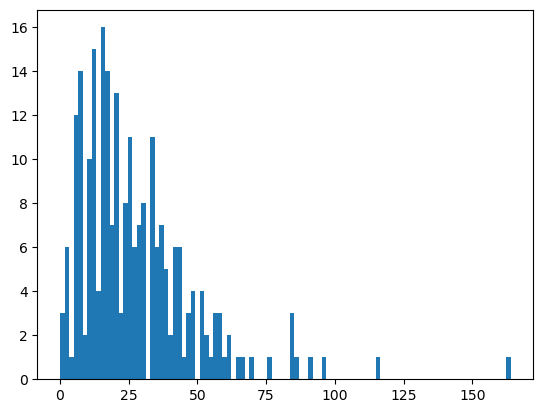

In [74]:
plt.hist(num_interactions, bins = 100)
plt.show()